In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Importing the protein data
k2 = []
k2d = []

f = open("../../../../../../Data/Proteins/DENV1/PrM/DENV1_Premembrane.txt", "r")
for x in f:
    if "DSS" in x:
        k2d.append(1)
    elif "DHF" in x:
        k2d.append(1)
    elif x[0] == ">":
        k2d.append(0)
    else:
        x = x.replace("\n", "")
        k2.append(x)

In [3]:
# Converting the array into DataFrame
k2 = pd.DataFrame(k2)

# Attaching the "Disease" label column to the input
k2["Disease"] = k2d

# Renaming the columns
k2 = k2.rename(index=str, columns={0: "Sequence", "Disease": "Disease"})

In [4]:
print("The combined shape of the given data is:", str(k2.shape))
print("The length of the combined data is:", str(len(k2.index)))
print("Does the combined data have any null value? ->", k2.isnull().values.any())

k2 = k2.dropna(how = 'any', axis = 0) 

# Shuffling the data and then taking a peek
k2 = k2.sample(frac = 1)
print(k2.head())

The combined shape of the given data is: (999, 2)
The length of the combined data is: 999
Does the combined data have any null value? -> False
                                              Sequence  Disease
700  FHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGELCE...        1
308  FHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGELCE...        0
804  FHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGELCE...        1
639  FHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGELCE...        1
261  FHLTTRGGEPHMIVSKQERGKSLLFKTSAGVNMCTLIAMDLGEFCE...        0


In [5]:
# Function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size = 6):
    return [sequence[x:x + size].lower() for x in range(len(sequence) - size + 1)]

k2['words'] = k2.apply(lambda x: getKmers(x['Sequence']), axis = 1)
k2 = k2.drop('Sequence', axis=1)

k2_texts = list(k2['words'])
for item in range(len(k2_texts)):
    k2_texts[item] = ' '.join(k2_texts[item])

In [6]:
# Creating y and printing the shape of it
y = k2.iloc[:, 0].values
print("The shape of y is:", y.shape)

The shape of y is: (999,)


In [7]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4))
x = cv.fit_transform(k2_texts)

# Print the shape of x
print("The shape of x matrix is:", x.shape)

The shape of x matrix is: (999, 731)


In [8]:
# Splitting the human dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42, stratify=y)

# Printing the shapes of the train and test matrices
print("The shape of x_train is:", X_train.shape)
print("The shape of y_train is:", y_train.shape)
print("The shape of x_test is:", X_test.shape)
print("The shape of y_test is:", y_test.shape)

The shape of x_train is: (799, 731)
The shape of y_train is: (799,)
The shape of x_test is: (200, 731)
The shape of y_test is: (200,)


In [9]:
print(len(str(X_train[0]).split()))

152


The ratio of the two severities in the train data: 1.4813664596273293


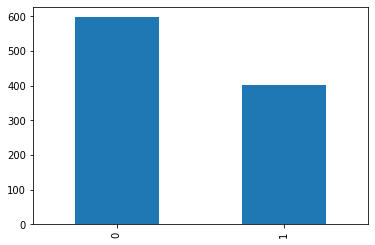

In [10]:
# Checking the balance of the disease severity
print("The ratio of the two severities in the train data:", list(y_train).count(0)/list(y_train).count(1))
k2["Disease"].value_counts().sort_index().plot.bar()

The ratio of the two severities in the test data: 1.5


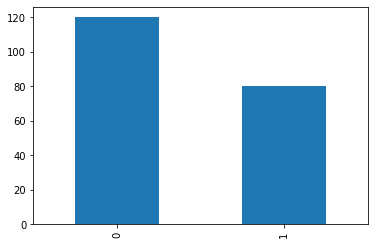

In [11]:
print("The ratio of the two severities in the test data:", list(y_test).count(0)/list(y_test).count(1))
pd.Series(y_test).value_counts().sort_index().plot.bar()

## Keras

In [12]:
# Importing the Keras libraries
from keras.models import Sequential
from keras.layers import Dense

# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=731, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.
W0119 10:14:26.397160 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0119 10:14:26.417109 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0119 10:14:26.421306 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [13]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

W0119 10:14:26.474019 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0119 10:14:26.505025 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0119 10:14:26.511642 139818259097408 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10)

W0119 10:14:26.971085 139818259097408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/150
799/799 [==============================] - 1s 626us/step - loss: 0.6577 - acc: 0.5970
Epoch 2/150
799/799 [==============================] - 0s 181us/step - loss: 0.6324 - acc: 0.5945
Epoch 3/150
799/799 [==============================] - 0s 172us/step - loss: 0.6227 - acc: 0.5882
Epoch 4/150
799/799 [==============================] - 0s 274us/step - loss: 0.6148 - acc: 0.5795
Epoch 5/150
799/799 [==============================] - 0s 273us/step - loss: 0.6107 - acc: 0.5957
Epoch 6/150
799/799 [==============================] - 0s 378us/step - loss: 0.6108 - acc: 0.6170
Epoch 7/150
799/799 [==============================] - 0s 362us/step - loss: 0.6119 - acc: 0.5995
Epoch 8/150
799/799 [==============================] - 0s 352us/step - loss: 0.6111 - acc: 0.5920
Epoch 9/150
799/799 [==============================] - 0s 364us/step - loss: 0.6107 - acc: 0.5745
Epoch 10/150
799/799 [==============================] - 0s 350us/step - loss: 0.6125 - acc: 0.5832
Epoch 11/150
799/79

799/799 [==============================] - 0s 326us/step - loss: 0.5910 - acc: 0.6295
Epoch 84/150
799/799 [==============================] - 0s 293us/step - loss: 0.5897 - acc: 0.6245
Epoch 85/150
799/799 [==============================] - 0s 296us/step - loss: 0.5885 - acc: 0.6283
Epoch 86/150
799/799 [==============================] - 0s 299us/step - loss: 0.5912 - acc: 0.6270
Epoch 87/150
799/799 [==============================] - 0s 289us/step - loss: 0.5893 - acc: 0.6258
Epoch 88/150
799/799 [==============================] - 0s 272us/step - loss: 0.5879 - acc: 0.6308
Epoch 89/150
799/799 [==============================] - 0s 309us/step - loss: 0.5858 - acc: 0.6270
Epoch 90/150
799/799 [==============================] - 0s 298us/step - loss: 0.5883 - acc: 0.6183
Epoch 91/150
799/799 [==============================] - 0s 308us/step - loss: 0.5882 - acc: 0.6220
Epoch 92/150
799/799 [==============================] - 0s 297us/step - loss: 0.5899 - acc: 0.6183
Epoch 93/150
799/799 [=

In [15]:
# evaluate the keras model
_, accuracy = model.evaluate(x, y)
print('Accuracy: %.2f' % (accuracy*100))

999/999 [==============================] - 0s 121us/step
Accuracy: 62.56


In [16]:
# make class predictions with the model
predictions = model.predict_classes(X_test)
# summarize the first 5 cases
for i in range(5):
    print('%s => %d (expected %d)' % (X_test[i], predictions[i], y_test[i]))

  (0, 140)	1
  (0, 241)	1
  (0, 405)	1
  (0, 628)	1
  (0, 610)	1
  (0, 497)	1
  (0, 198)	1
  (0, 180)	1
  (0, 117)	1
  (0, 457)	1
  (0, 246)	1
  (0, 420)	1
  (0, 311)	1
  (0, 687)	1
  (0, 542)	1
  (0, 330)	1
  (0, 472)	1
  (0, 123)	1
  (0, 501)	1
  (0, 212)	1
  (0, 336)	1
  (0, 544)	1
  (0, 386)	1
  (0, 364)	1
  (0, 147)	1
  :	:
  (0, 13)	1
  (0, 280)	1
  (0, 226)	1
  (0, 617)	1
  (0, 535)	1
  (0, 302)	1
  (0, 605)	1
  (0, 479)	1
  (0, 322)	1
  (0, 205)	1
  (0, 284)	1
  (0, 276)	1
  (0, 143)	1
  (0, 289)	1
  (0, 393)	1
  (0, 396)	1
  (0, 728)	1
  (0, 318)	1
  (0, 56)	1
  (0, 467)	1
  (0, 510)	1
  (0, 300)	1
  (0, 579)	1
  (0, 126)	1
  (0, 578)	1 => 0 (expected 0)
  (0, 140)	1
  (0, 241)	1
  (0, 405)	1
  (0, 628)	1
  (0, 610)	1
  (0, 497)	1
  (0, 198)	1
  (0, 180)	1
  (0, 117)	1
  (0, 457)	1
  (0, 246)	1
  (0, 420)	1
  (0, 311)	1
  (0, 687)	1
  (0, 542)	1
  (0, 330)	1
  (0, 472)	1
  (0, 123)	1
  (0, 501)	1
  (0, 212)	1
  (0, 336)	1
  (0, 544)	1
  (0, 386)	1
  (0, 364)	1
  (0, 147)	1
  :